In [3]:
from imports import *

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
warnings.filterwarnings("ignore")

#### Load data, split and create dataset

In [6]:
timeseries = process_file()
len(timeseries)

154

In [7]:
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

In [127]:
lookback=7
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

from utils import scale_data, LogMaxAbsScaler

X_train, X_test, y_train, y_test, scaler_x, scaler_y = scale_data(X_train, X_test, y_train, y_test)#, scaler_cls=LogMaxAbsScaler)

print("X_train", X_train.shape, "y_train", y_train.shape)
print("X_test",X_test.shape, "y_test",y_test.shape)



X_train torch.Size([96, 7, 1]) y_train torch.Size([96, 7, 1])
X_test torch.Size([44, 7, 1]) y_test torch.Size([44, 7, 1])


#### Defining LSTM Model and hyperparameters

In [298]:
from model import LSTMModel

model = LSTMModel(input_size=lookback, num_layers=1, hidden_size=15)
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=14, drop_last=True)

#### Training

In [299]:
from model import train_model
train_loss, train_rmse = train_model(model, loader, optimizer, loss_fn, n_epochs=700, print_interval=50, seed=42)

Epoch 50/700, Train Loss: 0.2618,  Train RMSE: 0.0558
Epoch 100/700, Train Loss: 0.2087,  Train RMSE: 0.0498
Epoch 150/700, Train Loss: 0.2012,  Train RMSE: 0.0489
Epoch 200/700, Train Loss: 0.2071,  Train RMSE: 0.0497
Epoch 250/700, Train Loss: 0.1972,  Train RMSE: 0.0485
Epoch 300/700, Train Loss: 0.1897,  Train RMSE: 0.0475
Epoch 350/700, Train Loss: 0.1887,  Train RMSE: 0.0474
Epoch 400/700, Train Loss: 0.1844,  Train RMSE: 0.0469
Epoch 450/700, Train Loss: 0.1723,  Train RMSE: 0.0453
Epoch 500/700, Train Loss: 0.1717,  Train RMSE: 0.0452
Epoch 550/700, Train Loss: 0.1691,  Train RMSE: 0.0449
Epoch 600/700, Train Loss: 0.1647,  Train RMSE: 0.0443
Epoch 650/700, Train Loss: 0.1622,  Train RMSE: 0.0439
Epoch 700/700, Train Loss: 0.1566,  Train RMSE: 0.0432


In [300]:
X_train.shape

torch.Size([96, 7, 1])

#### Evaluating on train and test

In [301]:
from model import evaluate_model_last_prediction
train_preds, train_loss, test_loss, train_rmse, test_rmse, test_preds = evaluate_model_last_prediction(model, X_train, y_train, X_test, y_test, scaler_y, loss_fn)

In [302]:
# creo un array concatenando las predicciones
train_preds = np.concatenate([tensor.flatten() for tensor in train_preds])
test_preds = np.concatenate([tensor.flatten() for tensor in test_preds])
len(train_preds), len(test_preds)

(96, 44)

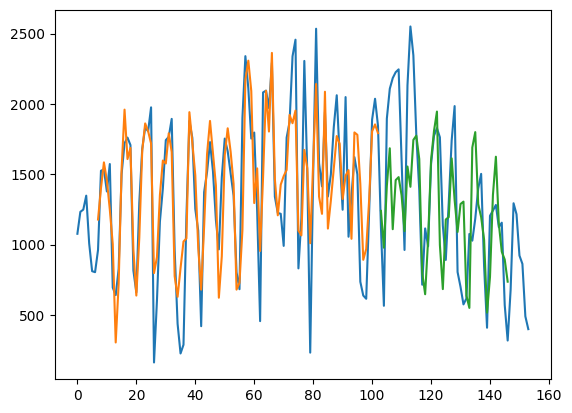

In [303]:
plt.plot(timeseries)
plt.plot(range(lookback, lookback + len(train_preds)), train_preds)
plt.plot(range(lookback + len(train_preds), lookback + len(train_preds) + len(test_preds)), test_preds)

In [281]:
test_loss, train_loss

([0.03694296255707741], [0.0240829698741436])

#### Plotting results

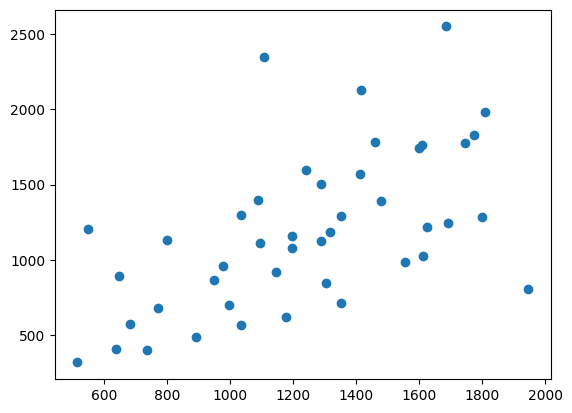

In [305]:
plt.scatter(test_preds, test[lookback:])

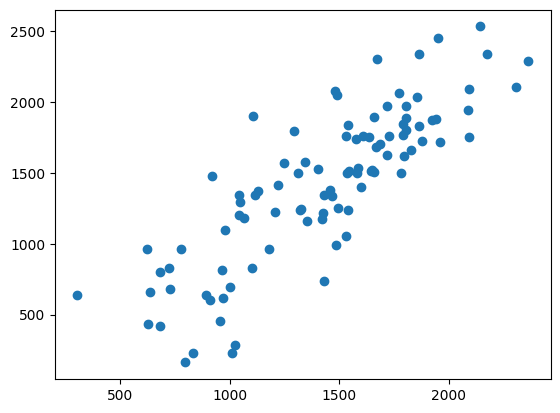

In [306]:
plt.scatter(train_preds, train[lookback:])